### PyTorch Practice - MNIST

Writing a pytorch code to classify handwritten images from the MNIST dataset.

Source for the dataset - [https://www.kaggle.com/datasets/hojjatk/mnist-dataset/data]

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load MNIST IDX files and split into train, validation, and test sets

def load_idx_images(path):
    with open(path,'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data[16:].reshape(-1, 28*28) / 255.0

def load_idx_labels(path):
    with open(path,'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data[8:]

# Load full training set
X_full = load_idx_images('../../Downloads/archive/train-images.idx3-ubyte')
y_full = load_idx_labels('../../Downloads/archive/train-labels.idx1-ubyte')
# Load test set
X_test = load_idx_images('../../Downloads/archive/t10k-images.idx3-ubyte')
y_test = load_idx_labels('../../Downloads/archive/t10k-labels.idx1-ubyte')
# Split off validation set from training data
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=10000, random_state=42)

In [4]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((50000, 784), (10000, 784), (50000,), (10000,))

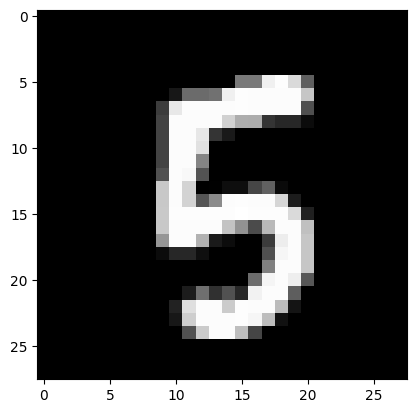

In [5]:
plt.imshow(X_train[1].reshape((28,28)), cmap='gray')

In [6]:
import torch
from torch import nn

In [7]:
device = torch.device("cpu")  # Fallback to CPU

In [8]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [9]:
model_0 = nn.Sequential(
    nn.Linear(in_features=784, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=10)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=10, bias=True)
)

In [10]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.CrossEntropyLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

In [11]:
X_train = torch.tensor(X_train).type(torch.float)
y_train = torch.tensor(y_train).type(torch.LongTensor)
X_test = torch.tensor(X_test).type(torch.float)
y_test = torch.tensor(y_test).type(torch.LongTensor)

In [12]:
y_train[:5]

tensor([8, 5, 1, 8, 9])

In [13]:
y_train_ohe = nn.functional.one_hot(y_train, num_classes=10).float()
y_test_ohe = nn.functional.one_hot(y_test, num_classes=10).float()

In [14]:
y_train[0]

tensor(8)

In [15]:
%%time

torch.manual_seed(42)

# Set the number of epochs
epochs = 300

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

model_x = model_0

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training - several operations like batch norm and drop out are stopped using inference mode 
    ## and is only used while training mode is why model.train is used
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_x(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = nn.functional.softmax(y_logits) # turn logits -> pred probs -> pred labls
  
    loss = loss_fn(y_logits, 
                   y_train_ohe) 
    y_pred = torch.tensor(np.argmax(torch.detach(y_pred).numpy(),axis=1)).type(torch.float)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_x(X_test).squeeze() 
        test_pred = nn.functional.softmax(test_logits)
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test_ohe)
        test_pred = torch.tensor(np.argmax(torch.detach(test_pred).numpy(),axis=1)).type(torch.float)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 20 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 2.30382, Accuracy: 9.48% | Test loss: 2.28231, Test acc: 18.48%
Epoch: 20 | Loss: 1.76766, Accuracy: 73.61% | Test loss: 1.72211, Test acc: 74.98%
Epoch: 40 | Loss: 1.13054, Accuracy: 79.85% | Test loss: 1.08681, Test acc: 80.88%
Epoch: 60 | Loss: 0.80503, Accuracy: 83.35% | Test loss: 0.77230, Test acc: 84.15%
Epoch: 80 | Loss: 0.65156, Accuracy: 85.14% | Test loss: 0.62372, Test acc: 85.95%
Epoch: 100 | Loss: 0.56561, Accuracy: 86.34% | Test loss: 0.54016, Test acc: 87.11%
Epoch: 120 | Loss: 0.51091, Accuracy: 87.27% | Test loss: 0.48691, Test acc: 88.15%
Epoch: 140 | Loss: 0.47308, Accuracy: 87.88% | Test loss: 0.45011, Test acc: 88.66%
Epoch: 160 | Loss: 0.44534, Accuracy: 88.36% | Test loss: 0.42321, Test acc: 89.19%
Epoch: 180 | Loss: 0.42406, Accuracy: 88.78% | Test loss: 0.40268, Test acc: 89.48%
Epoch: 200 | Loss: 0.40714, Accuracy: 89.09% | Test loss: 0.38646, Test acc: 89.71%
Epoch: 220 | Loss: 0.39329, Accuracy: 89.35% | Test loss: 0.37326, Test acc: 89.96%

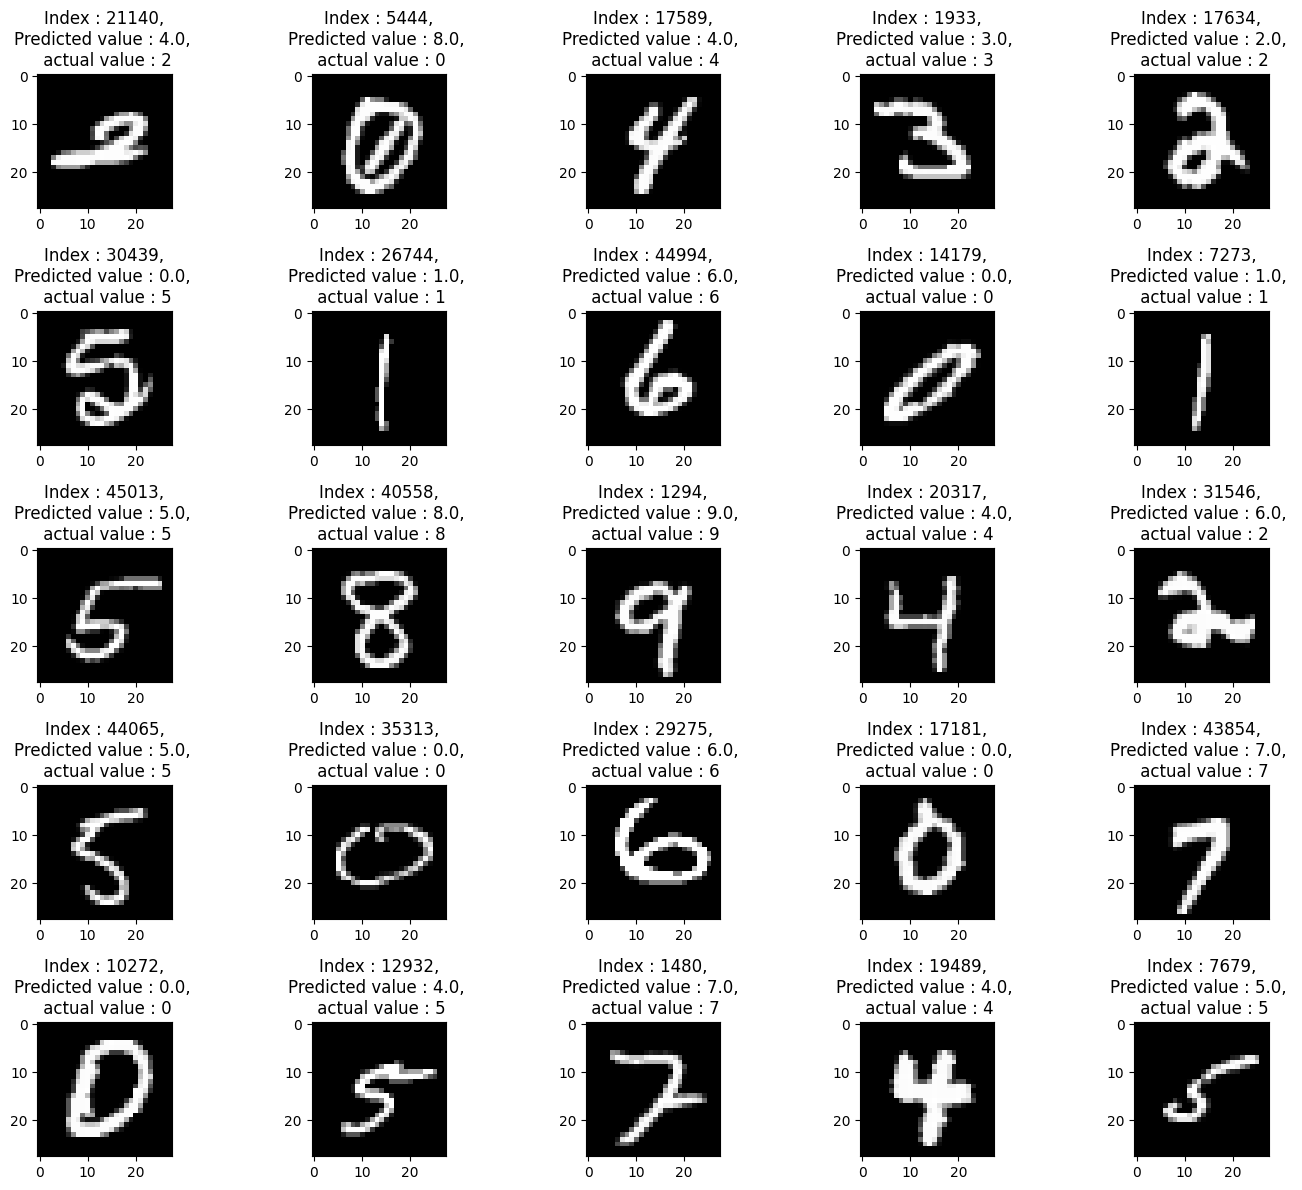

In [16]:
fig, ax = plt.subplots(5,5,figsize=(14,12))

for i in range(5):
    for j in range(5):
        # idx = (i+1)*j
        idx = np.random.randint(low=0,high=50000)
        x = X_train[idx].reshape((28,28))
        y = y_train[idx]
        ax[i][j].imshow(x, cmap='gray')
        ax[i][j].set_title(f"Index : {idx},\nPredicted value : {y_pred[idx]}, \n actual value : {y}")

fig.tight_layout();

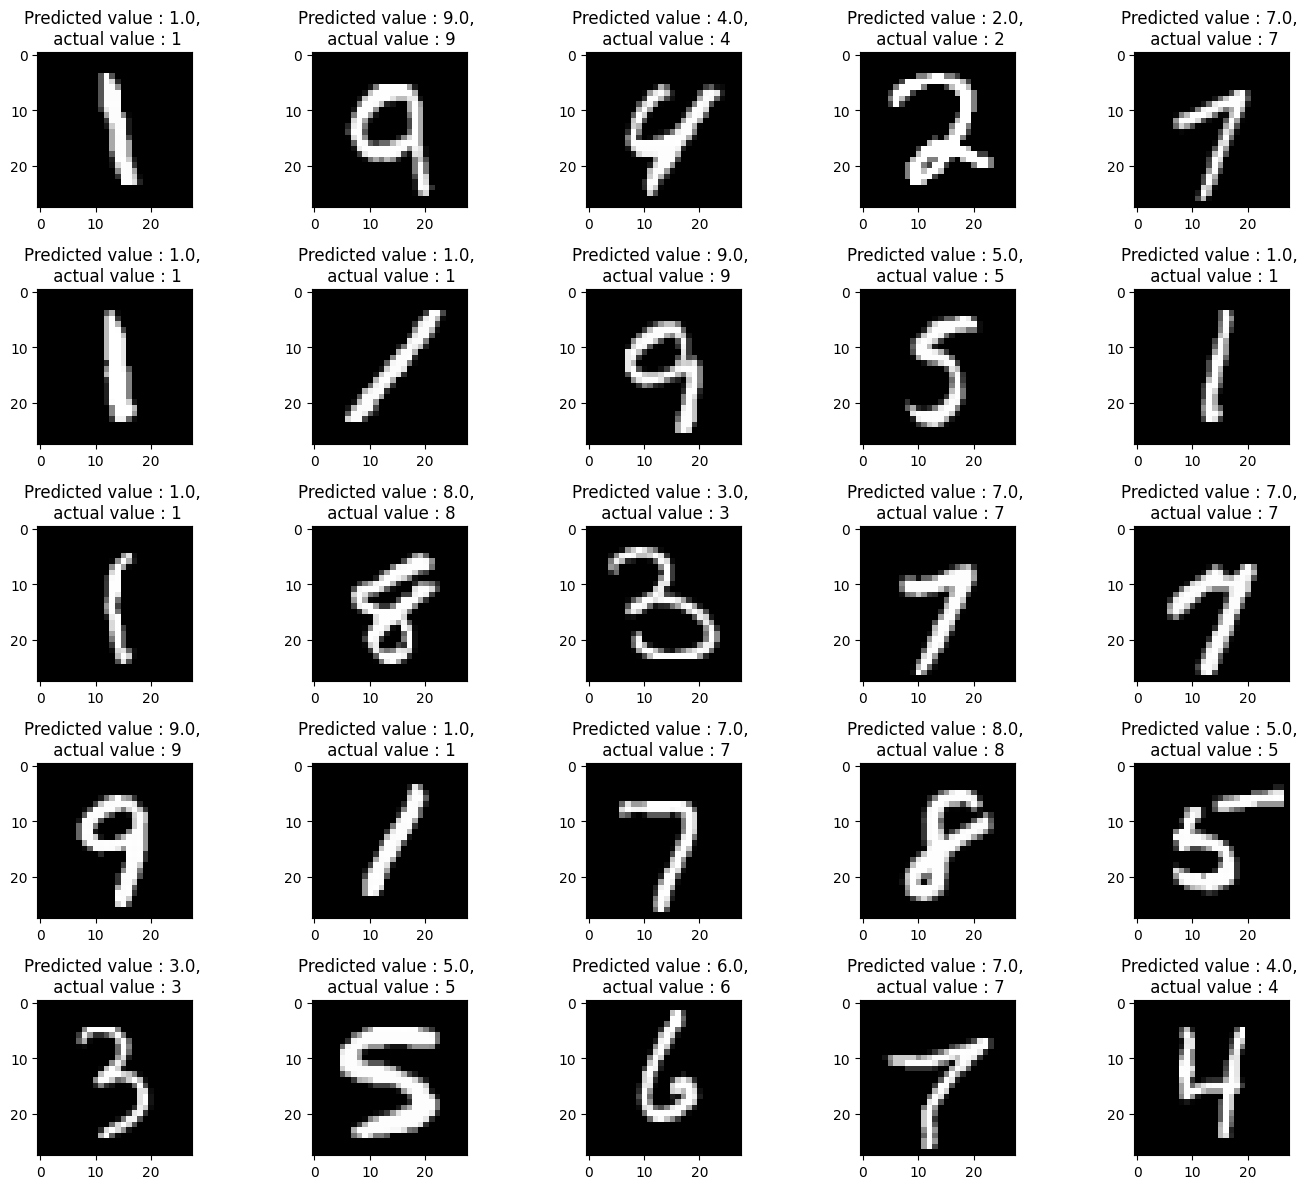

In [18]:
fig, ax = plt.subplots(5,5,figsize=(14,12))

for i in range(5):
    for j in range(5):
        # idx = (i+1)*j
        idx = np.random.randint(low=0,high=10000)
        x = X_test[idx].reshape((28,28))
        y = y_test[idx]
        ax[i][j].imshow(x, cmap='gray')
        ax[i][j].set_title(f"Predicted value : {test_pred[idx]}, \n actual value : {y}")

fig.tight_layout();